# MobileNetV3 YOLOv3 for Text Detection

A text detection model based on MobileNetV3 and YOLOv3.<br>
Pruned and quantized for deployment on edge devices.

- [x] Pretrained MobileNetV2 backbone
- [x] YOLOv3 top end
- [x] Basic Pruning, Quantization integration
- [x] Training pipeline (for ICDAR 2015)
- [x] Switch backbone to MobileNetV3
- [x] Mixed Precision Training
- [x] Advanced Pruning and quantization

- [ ] Basic Inference
- [ ] Performance Evaluation
- [ ] Deflate Jupyter Notebook into file structure
- [ ] Advanced training pipeline (COCO-Text dataset, batch augmentation, etc.)
- [ ] Live Image-Feed Inference

In [1]:
!pip install torch-optimizer

In [1]:
import gc
import csv
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch_optimizer as optim
import torchvision.models as models
import matplotlib.patches as patches
import torch.nn.utils.prune as prune

from PIL import Image
from pathlib import Path
from torchvision import transforms
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

%matplotlib inline

---

In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42);

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using training device: {device}")

batch_size = 32
num_workers = 4
num_classes = 1
learning_rate = 2e-4
num_epochs = 25
warmup_epochs = 10
weight_decay = 1e-4
swa_kickoff = 0.7
optim_k = 5
optim_alpha = 0.5
warmup_start = 0.3
scheduler_t0 = 2
scheduler_tmult = 2
swa_lr = 1e-3
swa_anneal_sched = 5
prune_amount = 0.3
smoothing_factor = 0.05
target_architecture = 'cuda'
dropout_rate = 0.2
mixup_alpha = 0.3

# https://www.kaggle.com/datasets/bestofbests9/icdar2015
dataset_path = Path("./icdar2015/")
train_path = dataset_path / 'ch4_training_images'
train_labels = dataset_path / 'ch4_training_localization_transcription_gt'
test_path = dataset_path / 'ch4_test_images'
test_labels = dataset_path / 'ch4_test_localization_transcription_gt'

model_path = 'pq_mobileyolov3.pth'

Using training device: cuda


---

## Model Definition

In [3]:
class DSConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(DSConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                   stride=stride, padding=kernel_size//2, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.activation(x)

class MobileYOLOv3(nn.Module):
    """
    In:  (batch_size, 3, 224, 224)
    Out: [(batch_size, 7, 7, num_anchors * (5 + num_classes)),
          (batch_size, 14, 14, num_anchors * (5 + num_classes))]
    5 + num_classes = 4 (x,y,w,h) + 1 (objectness) + num_classes (class probabilities)
    """
    def __init__(self, num_classes=1, num_anchors=3):
        super(MobileYOLOv3, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors

        self.mobilenet = nn.Sequential(*list(models.mobilenet_v3_small(weights='IMAGENET1K_V1').features))
        self.conv2 = DSConv(576, 192, kernel_size=1)
        self.conv3 = DSConv(192, 384, kernel_size=3)
        self.det1 = nn.Conv2d(384, num_anchors * (5 + num_classes), kernel_size=1)
        
        self.conv4 = DSConv(384, 128, kernel_size=1)
        self.upsample = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.conv5 = DSConv(128 + 48, 128, kernel_size=3)
        self.det2 = nn.Conv2d(128, num_anchors * (5 + num_classes), kernel_size=1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        skip_out = None
        for i, layer in enumerate(self.mobilenet):
            x = layer(x)
            # Using 8th MobileNetV3 layer as skip connection
            if i == 8:
                skip_out = x # (batch_size, 48, 14, 14)

        # 'Coarse' detection
        x = self.conv2(x)   # (batch_size, 256, 7, 7)
        x = self.conv3(x)   # (batch_size, 512, 7, 7)
        det1 = self.det1(self.dropout(x)).permute(0, 2, 3, 1).contiguous() # (batch_size, 7, 7, num_anchors * (5 + num_classes))

        # Skip connection
        x = self.conv4(x)     # (batch_size, 128, 7, 7)
        x = self.upsample(x)  # (batch_size, 128, 14, 14)
        x = torch.cat([x, skip_out], dim=1)  # (batch_size, 128 + 48, 14, 14)

        # 'Fine' detection
        x = self.conv5(x)  # (batch_size, 128, 14, 14)
        det2 = self.det2(self.dropout(x)).permute(0, 2, 3, 1).contiguous() # (batch_size, 14, 14, num_anchors * (5 + num_classes))

        # [(batch_size, 7, 7, num_anchors * (5 + num_classes)),
        #  (batch_size, 14, 14, num_anchors * (5 + num_classes))]
        return [det1, det2]

---

## Pruning & Quantization Definition

In [4]:
def prune_model(model, amount=0.2):
    """
    Weed out amount% weakest model weights.
    """
    for _, module in model.named_modules():
        if isinstance(module, DSConv):
            # Depthwise convolution pruning
            prune.l1_unstructured(module.depthwise, name='weight', amount=amount)
            prune.ln_structured(module.depthwise, name='weight', amount=amount, n=2, dim=0)
            prune.remove(module.depthwise, 'weight')            
            # Pointwise convolution pruning
            prune.l1_unstructured(module.pointwise, name='weight', amount=amount)
            prune.ln_structured(module.pointwise, name='weight', amount=amount, n=2, dim=0)
            prune.remove(module.pointwise, 'weight')
    parameters_to_prune = [(module, 'weight') for module in model.modules() if isinstance(module, (nn.Conv2d, nn.Linear))]
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=amount / 2)
    return model

def quantize_model(model, device):
    """
    Reduce numeric precision of weights and activations.
    """
    model = model.cpu()
    quantized_model = torch.quantization.quantize_dynamic(model, {nn.Conv2d, nn.Linear}, dtype=torch.qint8, inplace=True)
    # inplace=True avoids deepcopy issues
    return quantized_model.to(device)

---

## Dataset

In [5]:
class ICDAR2015(Dataset):
    """
    ICDAR2015 Dataset for YOLOv3 training.
    """
    def __init__(self, input_path, label_path, num_classes=1, num_anchors=3, img_size=(224, 224), img_format='.jpg', anchors=None):
        self.input_path = Path(input_path)  # Path to images
        self.label_path = Path(label_path)  # Path to labels
        self.num_classes = num_classes      # Number of associable classes
        self.num_anchors = num_anchors      # Number of predictable distinct objects per grid tile
        self.img_size = img_size            # Image size
        self.batch_count = 0                # Batch counter
        self.anchors = anchors if anchors is not None else [(0.28, 0.35), (0.43, 0.58), (0.62, 0.78)]
        # Encounter same image multiple times, different augmentations each time
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.ToTensor()
        ])
        self.files = self._assemble_files(img_format=img_format)
        self.labels = [self._parse_label(label, Image.open(img).size) for img, label in self.files]

    def _assemble_files(self, img_format):
        image_files, data = list(self.input_path.glob(f'*{img_format}')), []
        for img_file in image_files:
            img_id = img_file.stem.split('_')[-1]
            label_file = self.label_path / f"gt_img_{img_id}.txt"
            if label_file.exists():
                data.append((img_file, label_file))
            else:
                print(f"Warning: No matching label file found for {img_file.name}")
        return data

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path, _ = self.files[idx]
        img = Image.open(img_path)
        img = self.transform(img)
        label = self.labels[idx]
        return img, label
    
    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        if self.index >= len(self):
            raise StopIteration
        item = self[self.index]
        self.index += 1
        return item
    
    def _to_grid(self, grid, box, grid_dim):
        grid_w, grid_h = grid_dim
        x, y, w, h, obj, _ = box
        # Grid cell coordinates
        grid_x, grid_y = int(x * grid_w), int(y * grid_h)
        # Convert to relative coordinates in grid
        x, y = x * grid_w - grid_x, y * grid_h - grid_y
        for anchor_idx, (anchor_w, anchor_h) in enumerate(self.anchors):
            anchor_slice = slice(anchor_idx * (5 + self.num_classes), (anchor_idx + 1) * (5 + self.num_classes))
            if grid[grid_x, grid_y, anchor_slice].sum() == 0: # Empty grid cell
                grid[grid_x, grid_y, anchor_slice][:4] = torch.tensor([x, y, w / anchor_w, h / anchor_h])
                grid[grid_x, grid_y, anchor_slice][4] = obj # Objectness
                break  # Assign to one anchor only

    def _parse_label(self, label_path, img_size):
        coarse_labels = torch.zeros((7, 7, self.num_anchors * (5 + self.num_classes)))
        fine_labels   = torch.zeros((14, 14, self.num_anchors * (5 + self.num_classes)))
        with open(label_path, 'r', encoding='utf-8-sig') as file:
            reader = csv.reader(file, delimiter=',')
            for row in reader:
                row = torch.tensor([float(i) for i in row[:8]])   # BBox Points
                x, y = (row[0::2].sum() / 4, row[1::2].sum() / 4) # Center Point
                w = row[0::2].max() - row[0::2].min()   # BBox Width
                h = row[1::2].max() - row[1::2].min()   # BBox Height
                # Ground Truth Labels might be logically overreaching
                x, y = min(x, img_size[0] - 1e-3), min(y, img_size[1] - 1e-3)
                w, h = min(w, img_size[0] - 1e-3), min(h, img_size[1] - 1e-3)
                # Normalize
                x, y = x / img_size[0], y / img_size[1]
                w, h = w / img_size[0], h / img_size[1]
                # Objectness, Class Probability (ignore for single-class usecases)
                obj = 1.0
                cls = torch.zeros(self.num_classes) if self.num_classes > 1 else 0.0
                # 4 (x,y,w,h) + 1 (objectness) + num_classes (class probabilities)
                box = torch.tensor([x, y, w, h, obj, cls] if self.num_classes == 1 else [x, y, w, h, obj] + cls.tolist())
                # Assign in coarse grid
                self._to_grid(coarse_labels, box, (7, 7))
                # Assign in fine grid
                self._to_grid(fine_labels, box, (14, 14))
        # Would've loved to separate the labels more distinctly, but GPU memory rules this out
        cat = torch.cat([coarse_labels.flatten(), fine_labels.flatten()], dim=0) # (4410)
        return cat

    def get_batch(self, batch_size, randomized=True):
        if randomized:
            indices = np.random.choice(len(self), batch_size, replace=False)
        else:
            indices = np.arange(self.batch_count, self.batch_count + batch_size) % len(self)
            self.batch_count += batch_size
        batch_images = torch.stack([self[i][0] for i in indices], dim=0) # Images
        batch_labels = torch.stack([self[i][1] for i in indices], dim=0) # Labels
        # (batch_size, 3, 224, 224), (batch_size, flat((7, 7, num_anchors * (5 + num_classes)) + (14, 14, num_anchors * (5 + num_classes))))
        return batch_images, batch_labels

    @staticmethod
    def collate_fn(batch):
        images, labels = zip(*batch)
        images = torch.stack(images, dim=0)
        labels = torch.stack(labels, dim=0)
        # (batch_size, 3, 224, 224), (batch_size, flat((7, 7, num_anchors * (5 + num_classes)), (14, 14, num_anchors * (5 + num_classes))))
        return images, labels

---

## Loss

In [6]:
class YoLoss(nn.Module):
    """
    Custom YOLOv3-based loss function.
    Returns a scalar loss value, normalized over batch size, based on:
    - Coordinate loss for boxes with IoU > threshold and IoU < threshold
    - Objectness loss
    - No-objectness loss
    - Class loss (only for objects)
    """
    def __init__(self, num_classes=1, num_anchors=3, lambda_coord=5, lambda_noobj=0.5, 
                 lambda_class=1, iou_threshold=0.5, focal_alpha=0.25, focal_gamma=2.0):
        super(YoLoss, self).__init__()
        self.num_classes = num_classes      # Expecting this many different classes
        self.num_anchors = num_anchors      # Amount of boxes each grid cell is capable of predicting
        self.lambda_coord = lambda_coord    # Penalty factor, coordinate misalignment
        self.lambda_noobj = lambda_noobj    # Another penalty factor, objectness misidentification
        self.lambda_class = lambda_class    # Final penalty factor, class misattribution
        self.iou_threshold = iou_threshold  # If IoU > threshold -> objectness = 1 -> Spacial box attribution guide
        self.focal_alpha = focal_alpha
        self.focal_gamma = focal_gamma

    def focal_loss(self, pred, target, alpha, gamma):
        BCE_loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
        pt = torch.exp(-BCE_loss)
        return alpha * (1 - pt) ** gamma * BCE_loss
        
    def compute_loss(self, predictions, targets):
        """
        predictions, targets: (batch_size, grid_size_x, grid_size_y, num_anchors * (5 + num_classes))
        out -> scalar loss value
        """
        b_size, grid_size_x, grid_size_y, _ = predictions.size()

        # Mend to (batch_size, grid_size_x, grid_size_y, num_anchors, 5 + num_classes)
        # Thankfully this stripes the tensor into the desired shape (num_anchors many breaks in the last dimension)
        predictions = predictions.view(b_size, grid_size_x, grid_size_y, self.num_anchors, 5 + self.num_classes)
        targets     = targets.view(b_size, grid_size_x, grid_size_y, self.num_anchors, 5 + self.num_classes)

        # Split into components
        p_xy    = predictions[..., :2]
        p_wh    = predictions[..., 2:4]
        p_obj   = predictions[..., 4]
        p_class = predictions[..., 5:]

        t_xy    = targets[..., :2]
        t_wh    = targets[..., 2:4]
        t_obj   = targets[..., 4]
        t_class = targets[..., 5:]

        # Coordinate Loss (Center + Width-Height Deviation) for cells containing an object
        coord_loss = self.lambda_coord * t_obj * (
            F.mse_loss(p_xy, t_xy, reduction='none').sum(-1) + 
            F.mse_loss(p_wh, t_wh, reduction='none').sum(-1)
        )
        
        # Penalize incorrect objectness predictions + non-objectness predictions
        obj_loss = self.focal_loss(p_obj, t_obj, self.focal_alpha, self.focal_gamma)
        no_obj_loss = self.lambda_noobj * (1 - t_obj) * obj_loss

        # 4. Class Loss with Focal Loss (if applicable)
        if self.num_classes > 1:
            # Penalize incorrect class predictions
            class_loss = self.lambda_class * t_obj * self.focal_loss(p_class, t_class, self.focal_alpha, self.focal_gamma).sum(-1)
        else:
            # No class-related loss calculation if only one class anyway
            class_loss = torch.zeros_like(coord_loss)

        # Total loss: sum of all components, divided by batch size
        total_loss = (coord_loss + obj_loss + no_obj_loss + class_loss).sum() / b_size

        return total_loss
    
    def forward(self, predictions, targets):
        b_size = predictions[0].shape[0]
        coarse_size = 7 * 7 * self.num_anchors * (5 + self.num_classes)
        fine_size = 14 * 14 * self.num_anchors * (5 + self.num_classes)
        flat_coarse, flat_fine = torch.split(targets, [coarse_size, fine_size], dim=1)
        t_coarse = flat_coarse.view(b_size, 7, 7, self.num_anchors * (5 + self.num_classes))
        t_fine = flat_fine.view(b_size, 14, 14, self.num_anchors * (5 + self.num_classes))
        p_coarse, p_fine = predictions
        return self.compute_loss(p_coarse, t_coarse) + self.compute_loss(p_fine, t_fine)

---

## Training

In [7]:
train_dataset = ICDAR2015(train_path, train_labels, num_classes)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                           num_workers=num_workers, collate_fn=ICDAR2015.collate_fn,
                           pin_memory=True)

val_dataset = ICDAR2015(test_path, test_labels, num_classes)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                         num_workers=num_workers, collate_fn=ICDAR2015.collate_fn,
                         pin_memory=True)

def evaluate(model, criterion, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            with torch.amp.autocast(device_type=str(device)):
                outputs = model(images)
                loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(data_loader)

def adaptive_gradient_clipping(model, clip_factor=0.01, eps=1e-3):
    for param in model.parameters():
        param_norm = torch.norm(param.grad)
        clip_value = clip_factor * (torch.norm(param) + eps)
        param.grad = param.grad * (clip_value / (param_norm + eps))

def mixup_data(x, y, alpha=mixup_alpha):
    '''Returns mixed inputs, i.e. messing with the image-label relationship'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [8]:
model = MobileYOLOv3(num_classes=num_classes).to(device)
criterion = YoLoss()

# Adam, but decoupling weight decay from the gradient update
base_optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Periodically look ahead, update weights by averaging weight updates at every k steps
optimizer = optim.Lookahead(base_optimizer, k=optim_k, alpha=optim_alpha)

# Increase learning rate gradually, prevent harsh updates early on
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_start, total_iters=warmup_epochs)

# Periodically run original learning rate, decaying it following a cosine curve over T_0 epochs
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=scheduler_t0, T_mult=scheduler_tmult)

# Avoids numerical underflow/overflow through scaling, helps maintain information in mixed-precision
scaler = torch.amp.GradScaler(enabled=(str(device) != 'cpu'))

# Running model param average, stabilizes training
swa_model = AveragedModel(model)

# Learning rate scheduler for SWA phase
swa_scheduler = SWALR(optimizer, swa_lr=swa_lr, anneal_strategy="cos", anneal_epochs=swa_anneal_sched)

In [9]:
lossi, losst = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for files, targets in train_loader:
        files = files.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        mixed_files, targets_a, targets_b, lam = mixup_data(files, targets)
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type=str(device)):
            outputs = model(mixed_files)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

        scaler.scale(loss).backward()
        adaptive_gradient_clipping(model)
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        
    epoch_loss /= len(train_loader)
    lossi.append(epoch_loss)
    
    t_loss = evaluate(model, criterion, val_loader, device)
    losst.append(t_loss)

    # SWA starts averaging model weights
    if epoch > num_epochs * swa_kickoff:
        swa_model.update_parameters(model)
        swa_scheduler.step()
    else:
        scheduler.step()
        
    # GPUs are expensive
    gc.collect()
    torch.cuda.empty_cache()

    # Print training and test loss
    print(f'Epoch [{epoch+1:3}/{num_epochs}] | Train: {epoch_loss:8.3f} | Test: {t_loss:8.3f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')

Epoch [  1/25] | Train:  207.754 | Test:  115.376 | LR: 0.000100
Epoch [  2/25] | Train:  145.512 | Test:  103.843 | LR: 0.000200
Epoch [  3/25] | Train:  108.376 | Test:   74.769 | LR: 0.000171
Epoch [  4/25] | Train:   75.872 | Test:   57.700 | LR: 0.000100
Epoch [  5/25] | Train:   58.042 | Test:   46.065 | LR: 0.000029
Epoch [  6/25] | Train:   52.241 | Test:   43.530 | LR: 0.000200
Epoch [  7/25] | Train:   46.931 | Test:   36.596 | LR: 0.000192
Epoch [  8/25] | Train:   40.539 | Test:   32.875 | LR: 0.000171
Epoch [  9/25] | Train:   36.887 | Test:   30.830 | LR: 0.000138
Epoch [ 10/25] | Train:   34.860 | Test:   29.344 | LR: 0.000100
Epoch [ 11/25] | Train:   33.672 | Test:   28.716 | LR: 0.000062
Epoch [ 12/25] | Train:   32.540 | Test:   28.278 | LR: 0.000029
Epoch [ 13/25] | Train:   32.212 | Test:   28.111 | LR: 0.000008
Epoch [ 14/25] | Train:   31.970 | Test:   28.161 | LR: 0.000200
Epoch [ 15/25] | Train:   32.177 | Test:   27.160 | LR: 0.000198
Epoch [ 16/25] | Train:  

In [10]:
# Use the 'swa_model' from here on
torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)

# Prune, Quantize
pruned_model = prune_model(swa_model, amount=prune_amount)
quantized_model = quantize_model(pruned_model, device)

# Save the quantized model
torch.save(quantized_model.state_dict(), model_path)

---

## Evaluate

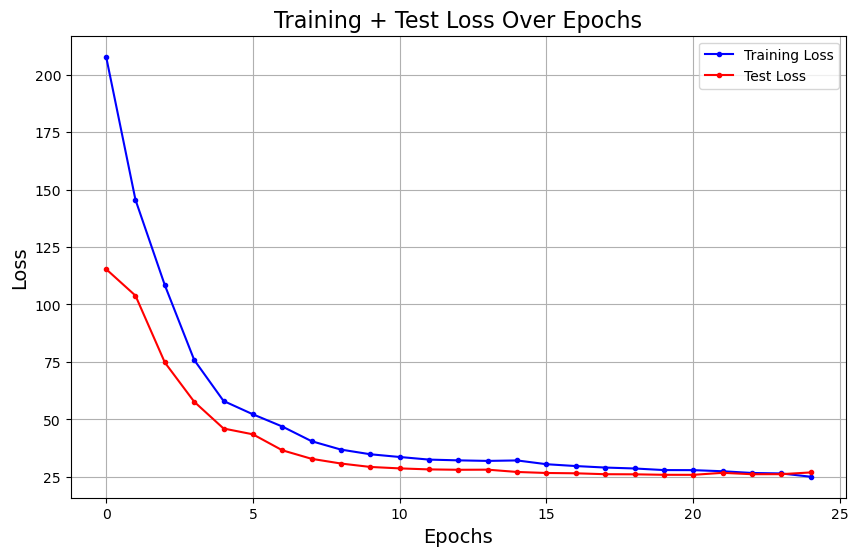

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), lossi, label="Training Loss", color='blue', marker='o', linestyle='-', markersize=3)
plt.plot(range(num_epochs), losst, label="Test Loss", color="red", marker='o', linestyle='-', markersize=3)

plt.title('Training + Test Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right')
plt.show();

In [21]:
def load_model(model_class, num_classes, model_path, target_device='cpu'):
    """
    Load a PyTorch model for inference on the target device, regardless of where it was originally trained.
    """
    if isinstance(target_device, str):
        target_device = torch.device(target_device)

    # Load to CPU first
    state_dict = torch.load(model_path, map_location=target_device, weights_only=False)
    
    if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']

    # Remove 'module.' prefix caused by SWA
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

    # Remove pruning-related keys
    new_state_dict = {}
    for key, value in state_dict.items():
        if 'weight_mask' not in key:
            new_key = key.replace('weight_orig', 'weight')
            new_state_dict[new_key] = value
        
    model = model_class(num_classes)
    model.load_state_dict(new_state_dict, strict=False)
    model = model.to(target_device)
    model.eval()
    return model

In [22]:
def yolo_to_icdar2015(predictions, original_sizes, conf_threshold=0.5, num_anchors=3):
    batch_size, grid_h, grid_w, _ = predictions.shape
    predictions = predictions.view(batch_size, grid_h, grid_w, num_anchors, -1)
    
    bboxes_per_image = []

    for img_idx in range(batch_size):
        boxes = []
        orig_w, orig_h = original_sizes[img_idx]

        for y in range(grid_h):
            for x in range(grid_w):
                for anchor in range(num_anchors):
                    pred = predictions[img_idx, y, x, anchor]
                    obj_conf = pred[4].sigmoid()
                    if obj_conf > conf_threshold:
                        cx, cy, w, h = pred[:4].sigmoid()
                        
                        # Convert to absolute coordinates
                        cx_abs = (x + cx) / grid_w * orig_w
                        cy_abs = (y + cy) / grid_h * orig_h
                        w_abs = w * orig_w
                        h_abs = h * orig_h

                        # Calculate corner coordinates
                        x_min = cx_abs - w_abs / 2
                        y_min = cy_abs - h_abs / 2
                        x_max = cx_abs + w_abs / 2
                        y_max = cy_abs + h_abs / 2

                        # Convert to four-point bounding box
                        box = [
                            x_min, y_min,  # Top-left
                            x_max, y_min,  # Top-right
                            x_max, y_max,  # Bottom-right
                            x_min, y_max   # Bottom-left
                        ]
                        boxes.append(box)
        
        bboxes_per_image.append(boxes)
    return bboxes_per_image

In [23]:
def process_batch(model, dataset, device, num_images=10, conf_threshold=0.5):
    model.eval()
    sampled_indices = random.sample(range(len(dataset)), num_images)
    original_imgs, original_sizes, batch_imgs = [], [], []

    for idx in sampled_indices:
        img, _ = dataset[idx]
        original_size = (img.shape[2], img.shape[1])  # (width, height)
        original_imgs.append(img.permute(1, 2, 0).cpu().numpy())  # Store as HWC numpy array
        original_sizes.append(original_size)
        batch_imgs.append(img)

    batch_tensor = torch.stack(batch_imgs).to(device)

    with torch.no_grad():
        predictions = model(batch_tensor)

    return yolo_to_icdar2015(predictions, original_sizes, conf_threshold), original_imgs

In [24]:
def visualize_predictions(model, dataset, device, num_images=10, conf_threshold=0.5):
    predicted_boxes, original_images = process_batch(model, dataset, device, num_images, conf_threshold)

    for img_idx in range(num_images):
        img = original_images[img_idx]
        img_disp = img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for display

        fig, ax = plt.subplots(1)
        ax.imshow(img_disp)
        boxes = predicted_boxes[img_idx]
        
        for box in boxes:
            x1, y1, x2, y2, x3, y3, x4, y4 = box
            rect = patches.Rectangle((x1, y1), x3 - x1, y3 - y1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
        
        plt.axis('off')  # Hide axes
        plt.show()

In [25]:
model = load_model(MobileYOLOv3, num_classes, model_path, 'cpu')

dataset = ICDAR2015(train_path, train_labels)
visualize_predictions(model, dataset, 'cpu', num_images=10, conf_threshold=0.6) # Still horrible

AttributeError: 'numpy.ndarray' object has no attribute 'permute'